# Multilayer Perceptrons

Description

# Table of Contents
- [Import Library](#import-library)
- [Read In CSV](#read-in-csv)
- [Train Model](#train-model)
    - [Neural Network 1](#neural-network-1)
    - [Neural Network 2](#neural-network-2)

## Import Library

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Read In CSV

In [2]:
eth = pd.read_csv('./data/ohlcv_daily.csv')

In [59]:
eth.fillna(eth.mean(), inplace=True)

# Train Model

## Neural Network 1

In [239]:
predictor_values = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment', 'tomorrow']

X = eth[predictor_values]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1],)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, 
                    epochs=500, 
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stop])

Epoch 1/500
57/57 [==============================] - 2s 5ms/step - loss: 0.7021 - accuracy: 0.4867 - val_loss: 0.6897 - val_accuracy: 0.5100
Epoch 2/500
57/57 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.4972 - val_loss: 0.6869 - val_accuracy: 0.5588
Epoch 3/500
57/57 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5139 - val_loss: 0.6873 - val_accuracy: 0.5410
Epoch 4/500
57/57 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5366 - val_loss: 0.6865 - val_accuracy: 0.5432
Epoch 5/500
57/57 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.5255 - val_loss: 0.6849 - val_accuracy: 0.5831
Epoch 6/500
57/57 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5327 - val_loss: 0.6892 - val_accuracy: 0.5078
Epoch 7/500
57/57 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5488 - val_loss: 0.6824 - val_accuracy: 0.5588
Epoch 8/500
5

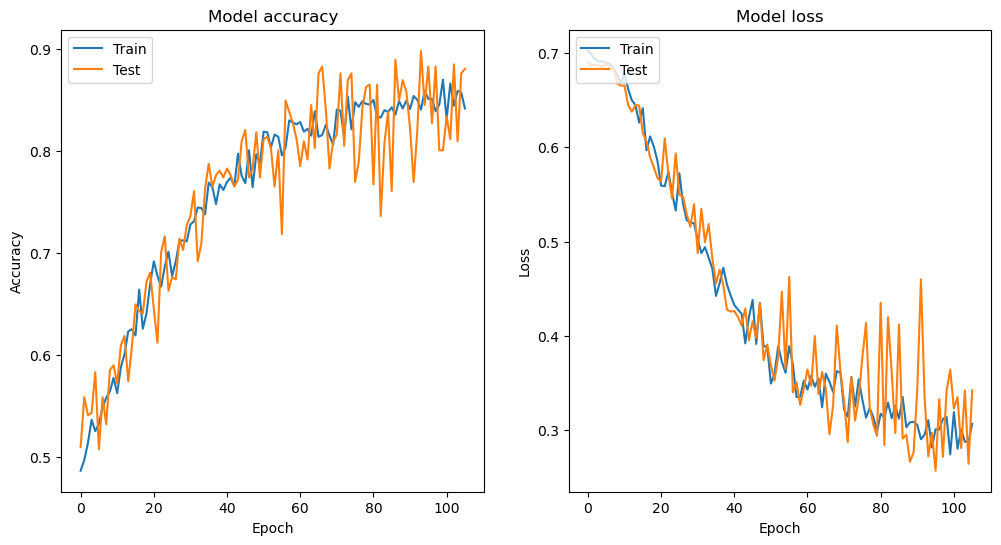

Final Test Accuracy: 88.03%


In [240]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

final_acc = history.history['val_accuracy'][-1]
final_acc = final_acc * 100
print(f"Final Test Accuracy: {final_acc:.2f}%")

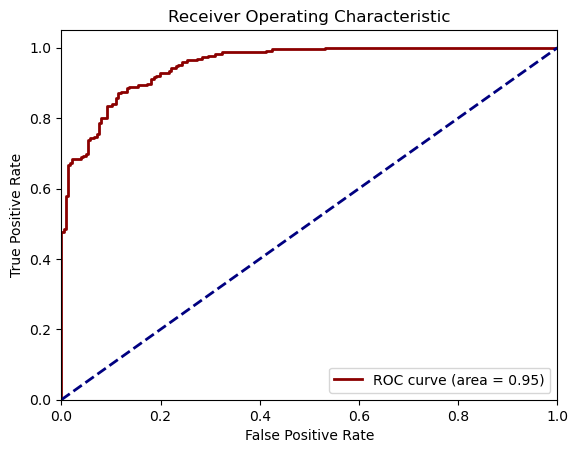

In [241]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show();

## Neural Network 2

In [216]:
predictor_values = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment', 'tomorrow']

X = eth[predictor_values]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1],)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), activity_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, 
                    epochs=500, 
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stop])

Epoch 1/500
57/57 [==============================] - 1s 5ms/step - loss: 3.2136 - accuracy: 0.5310 - val_loss: 2.2907 - val_accuracy: 0.5188
Epoch 2/500
57/57 [==============================] - 0s 3ms/step - loss: 2.6550 - accuracy: 0.5521 - val_loss: 2.0398 - val_accuracy: 0.5033
Epoch 3/500
57/57 [==============================] - 0s 2ms/step - loss: 2.3231 - accuracy: 0.5726 - val_loss: 1.8596 - val_accuracy: 0.5632
Epoch 4/500
57/57 [==============================] - 0s 3ms/step - loss: 2.0695 - accuracy: 0.5942 - val_loss: 1.7298 - val_accuracy: 0.5920
Epoch 5/500
57/57 [==============================] - 0s 3ms/step - loss: 1.8556 - accuracy: 0.6197 - val_loss: 1.6023 - val_accuracy: 0.5987
Epoch 6/500
57/57 [==============================] - 0s 3ms/step - loss: 1.7010 - accuracy: 0.6170 - val_loss: 1.5155 - val_accuracy: 0.6341
Epoch 7/500
57/57 [==============================] - 0s 3ms/step - loss: 1.5506 - accuracy: 0.6552 - val_loss: 1.3986 - val_accuracy: 0.6253
Epoch 8/500
5

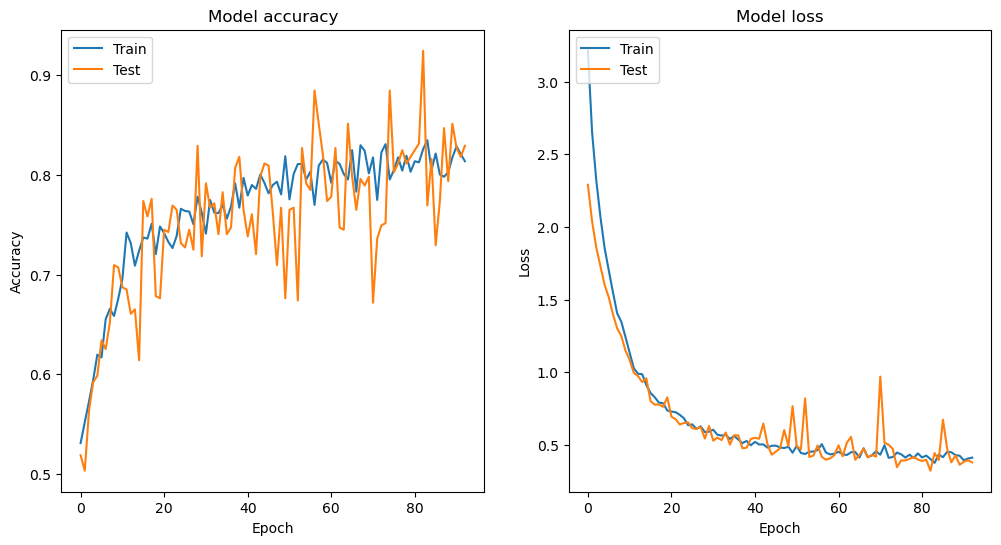

Final Test Accuracy: 82.93%


In [217]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

final_acc = history.history['val_accuracy'][-1]
final_acc = final_acc * 100
print(f"Final Test Accuracy: {final_acc:.2f}%")

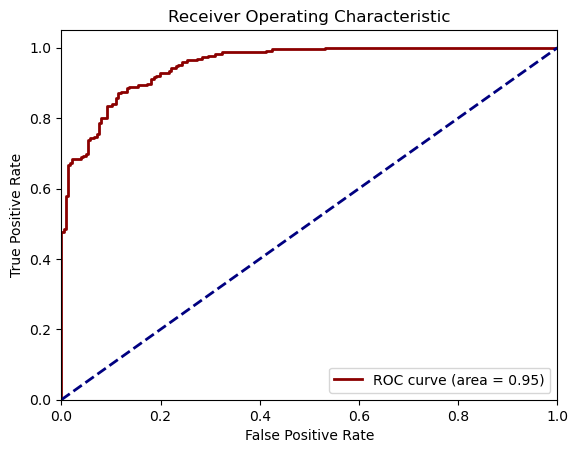

In [218]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Both neural networks that were architectured achieved 80% or greater in predicting price movement

In [219]:
predictor_values = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment', 'tomorrow']

X = eth[predictor_values]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_shape = (X_train_scaled.shape[1],)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, 
                    epochs=500, 
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stop])

Epoch 1/500
57/57 [==============================] - 2s 13ms/step - loss: 0.7001 - accuracy: 0.4983 - val_loss: 0.6923 - val_accuracy: 0.5432
Epoch 2/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6950 - accuracy: 0.5127 - val_loss: 0.6939 - val_accuracy: 0.5011
Epoch 3/500
57/57 [==============================] - 1s 11ms/step - loss: 0.6944 - accuracy: 0.4911 - val_loss: 0.6920 - val_accuracy: 0.5388
Epoch 4/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6947 - accuracy: 0.4917 - val_loss: 0.6924 - val_accuracy: 0.4989
Epoch 5/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6936 - accuracy: 0.5100 - val_loss: 0.6928 - val_accuracy: 0.4678
Epoch 6/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6933 - accuracy: 0.5249 - val_loss: 0.6919 - val_accuracy: 0.5277
Epoch 7/500
57/57 [==============================] - 1s 10ms/step - loss: 0.6937 - accuracy: 0.5133 - val_loss: 0.6921 - val_accuracy: 0.5188
Epoch 

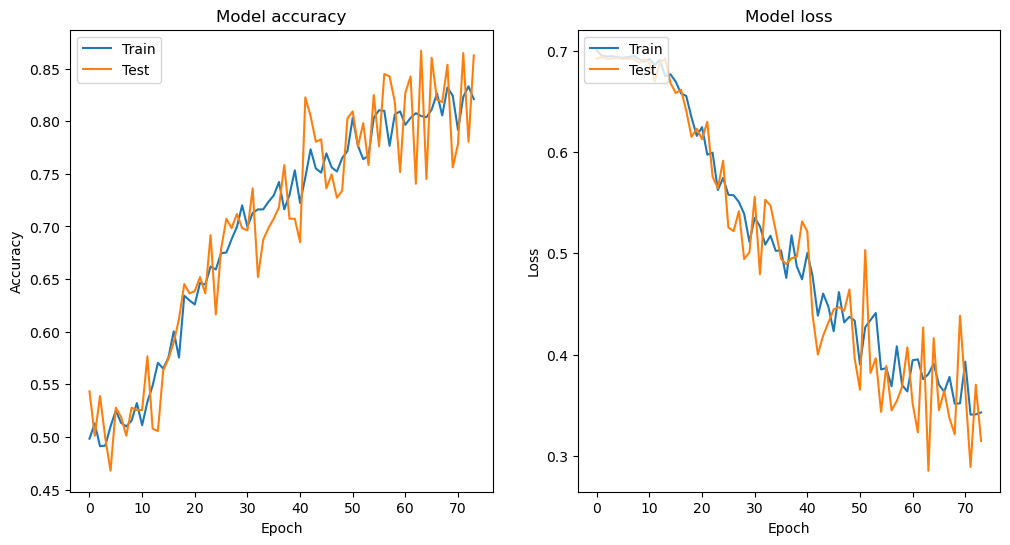

Final Test Accuracy: 86.25%


In [220]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

final_acc = history.history['val_accuracy'][-1]
final_acc = final_acc * 100
print(f"Final Test Accuracy: {final_acc:.2f}%")

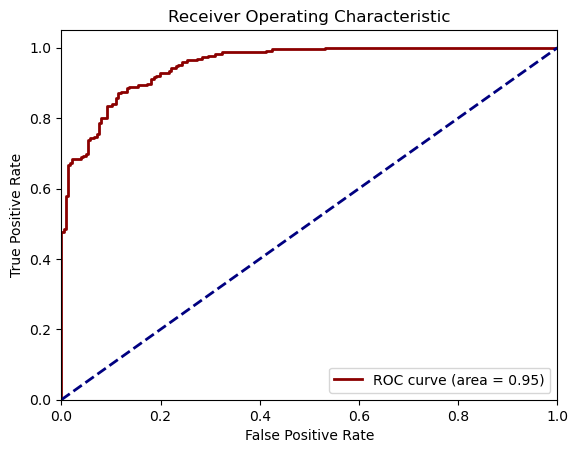

In [221]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()